<h2>Lab work Waves Unit 
 (module CIEM3000)</h2>

<h1 style="color:#00BFFF;">Data analysis labwork prep</h1>
<hr style="height:2px;border:none;color:#333;" />

This notebook will help you start with your data analysis. The main objective is to obtain a data series from the daisy files you generated during the experiments, which you can then use to answer your research questions.

<h3 style="color:#00BFFF;">Loading in some basic packages for calculations and operations </h3>
<hr style="height:1.5px;border:none;color:#333;" />

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend #importing scipy.signal package for detrending
from scipy.fftpack import fft #importing Fourier transform package
from scipy.stats import chi2 #importing confidence interval package
import wave_toolbox as wt

plt.rcParams['figure.figsize'] = (15, 5)  # Set the width and height of plots in inches
plt.rcParams.update({'font.size': 13})  # Change this value to your desired font size

<h3 style="color:#00BFFF;">Data import </h3>
<hr style="height:1.5px;border:none;color:#333;" />

First import the data for both the EMF's and the wavegauges, using `np.loadtxt`, with `dtype = float`. The first rows of your ASC are headers that provide information of the data, the parameter `skiprows` avoid these. Note that the information of all sensors is stored in the array. Then store the time in an array and EMF and wavegauge data separately. Open the ASC file with a text editor to verify what each column represents.

In [2]:
# fileName = 'run_test.ASC'
# data  = np.array(np.loadtxt(  'run_test.ASC', dtype = float, delimiter = ';', usecols=range(12), skiprows = 7))

# plt.plot(data[:, 0], data[:, 1])
# plt.xlabel('time (s)')
# plt.ylabel('???')
# plt.grid()

In [3]:
fdir = 'Flume'
filesep = '/'
numRun = [1,2,4,5,6,8,9,10,'regular']
res ={}

for i in numRun:
    if i != 'regular':
        fname = 'run' + str(i)
    else:
        fname = 'regular'

    fLoc = fdir + filesep + fname + '.ASC'

    data = np.genfromtxt(fLoc,delimiter=';',skip_header=7,dtype=float)

    t = data[:,0]
    wl = data[:,1::2]
    v= data[:,2:-1:2]

    res[fname] = {
            'time' : t,
            'wl' : wl,
            'vel' : v,
        }


In [4]:
# plot water level data (in Volt)
for d in res.keys():
    plt.figure(figsize=[20,20])
    #plt.title(d,pad=10)
    plt.tight_layout()
    for i in range(6):
        plt.subplot(6,1,i+1) 
        plt.plot(res[d]['time'],res[d]['wl'][:,i],label='WG'+str(i+1))
        plt.legend()
        
    plt.savefig('Figure'+filesep+'wl_'+d+'.png',bbox_inches='tight')
    plt.close()

In [5]:
# plot velocity data (in Volt)
for d in res.keys():
    plt.figure(figsize=[15,30])
    for i in range(5):
        plt.subplot(5,1,i+1)
        plt.plot(res[d]['time'],res[d]['vel'][:,i],label='WG'+str(i+1))
        plt.legend()
    plt.savefig('Figure'+filesep+'vel_'+d+'.png')
    plt.close()

<h1 style="color:#00BFFF;"> Data postprocessing </h1>
<hr style="height:2px;border:none;color:#333;" />

<h3 style="color:#00BFFF;">Data calibration </h3>
<hr style="height:1.5px;border:none;color:#333;" />

The next step is to convert from volts to flow velocities for EMF and from volts to meters for WG. Every EMF follows the same conversion formula $u=0.1023x$, where $x$ is the data read. Do not worry yet about the initial offset (i.e.,flow velocities not being 0 at the beginning of the run), that will be removed in the next step.

In [6]:
for d in res.keys():
    res[d]["vlm"] = res[d]["vel"] * 0.1023

Different parameters are used for converting the wave gauge data to metres. Use the following formula $\eta=coefficient * x$, where $x$ is the data read and the coeffificents are 0.0253,  0.0248 , 0.0249 , 0.0245 , 0.0244 , 0.00502. The order goes from offshore to onshore (the first one is the closest to the wave generator). Again, do not worry yet about the vertical offset. 


In [7]:
coefficients = [0.0253, 0.0248, 0.0249, 0.0245, 0.0244, 0.00502]
for d in res.keys():
    res[d]["eta"]=np.copy(res[d]["wl"])
    for i in range(6):     
        res[d]["eta"][:,i] = res[d]["wl"][:,i]* coefficients[i]
        print(f"{d} measurement {i} = {np.mean(res[d]['eta'][i])}")
        res[d]["eta"][:,i] -= np.mean(res[d]["eta"][i])
#    for i in range(6):
    #    res[d]["eta"][i] = res[d]["wl"]* coefficients[i]

run1 measurement 0 = -0.030486000000000003
run1 measurement 1 = -0.022071666666666667
run1 measurement 2 = -0.026601888888888887
run1 measurement 3 = -0.017209074074074075
run1 measurement 4 = -0.01279639506172839
run1 measurement 5 = 0.019234937448559673
run2 measurement 0 = -0.08381933333333332
run2 measurement 1 = -0.03822411111111111
run2 measurement 2 = -0.06185342592592593
run2 measurement 3 = -0.016667021604938274
run2 measurement 4 = -0.00649435133744856
run2 measurement 5 = 0.03515470721879287
run4 measurement 0 = -0.16428316666666667
run4 measurement 1 = -0.14739780555555557
run4 measurement 2 = -0.08320533796296295
run4 measurement 3 = -0.08169878163580246
run4 measurement 4 = -0.0529163180298354
run4 measurement 5 = 0.08617410164180384
run5 measurement 0 = -0.062236999999999994
run5 measurement 1 = -0.055321499999999996
run5 measurement 2 = -0.03447541666666667
run5 measurement 3 = -0.041982513888888885
run5 measurement 4 = -0.023358594907407413
run5 measurement 5 = 0.03670

In [8]:
print(res["run1"]["wl"])
print(res["run1"]["eta"])

[[ 0.28  0.    0.03 -0.03 -0.02 -0.17]
 [ 0.28  0.    0.03 -0.01 -0.02 -0.17]
 [ 0.28  0.    0.03 -0.02 -0.02 -0.18]
 ...
 [ 0.3  -0.01  0.02  0.08 -0.02 -0.05]
 [ 0.3  -0.02  0.02  0.   -0.03 -0.14]
 [ 0.3  -0.03  0.01  0.1  -0.05 -0.19]]
[[ 0.03757     0.02207167  0.02734889  0.01647407  0.0123084  -0.02008834]
 [ 0.03757     0.02207167  0.02734889  0.01696407  0.0123084  -0.02008834]
 [ 0.03757     0.02207167  0.02734889  0.01671907  0.0123084  -0.02013854]
 ...
 [ 0.038076    0.02182367  0.02709989  0.01916907  0.0123084  -0.01948594]
 [ 0.038076    0.02157567  0.02709989  0.01720907  0.0120644  -0.01993774]
 [ 0.038076    0.02132767  0.02685089  0.01965907  0.0115764  -0.02018874]]


<h3 style="color:#00BFFF;">Offset removal and other quality checks </h3>
<hr style="height:1.5px;border:none;color:#333;" />

Remove the vertical offset in the timeseries, i.e. transform the time series so that the elevation and velocities are zeros when the water is at rest. First, visually inspect the data to see for what time interval this is still the case. Then determine the offset, for example via the mean elevation or velocity over this time interval. The offset is removed by subtracting this mean value from the entire dataset. Note that the offset is different for each sensor and might vary per run. 

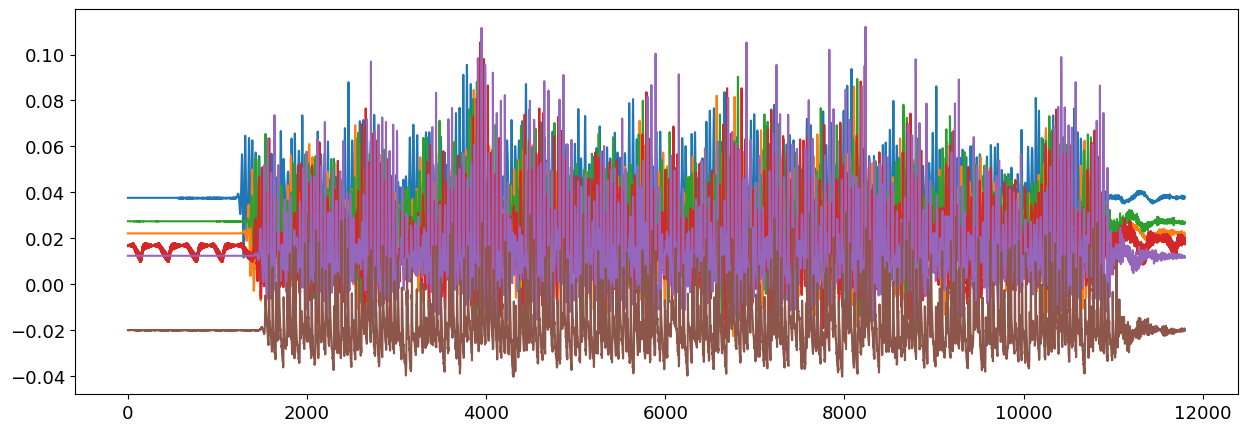

In [9]:
plt.plot(res['run1']['eta'])

If you are working with the velocity timeseries, make sure that the instruments have been orientated properly. One quick way to do so is to check that the horizontal velocity and elevation at the start of the run are in phase. Of one sensor plot the first seconds of the WG and EMF, the signals must be one on top of the other with a different scale. Check it for every sensor.

<h3 style="color:#00BFFF;"> Stationarity  </h3>
<hr style="height:1.5px;border:none;color:#333;" />

The wavemaker starts generating waves at the offshore boundary over an initially flat water surface. It will take some time before stationary conditions are reached (e.g., the waves need to propagate over the full domain and back in case of reflection, and setup needs time to build up). Do not forget to remove this "spinup time" before calculating any wave statistics. 
<br>
To determine the spinup time, visually check at what time the sensors start measuring waves and add 60 seconds to ensure stationarity. Remove this data from your time series. Follow a similar process to delete the last part of the run, once the paddle was stopped. 

1200.0

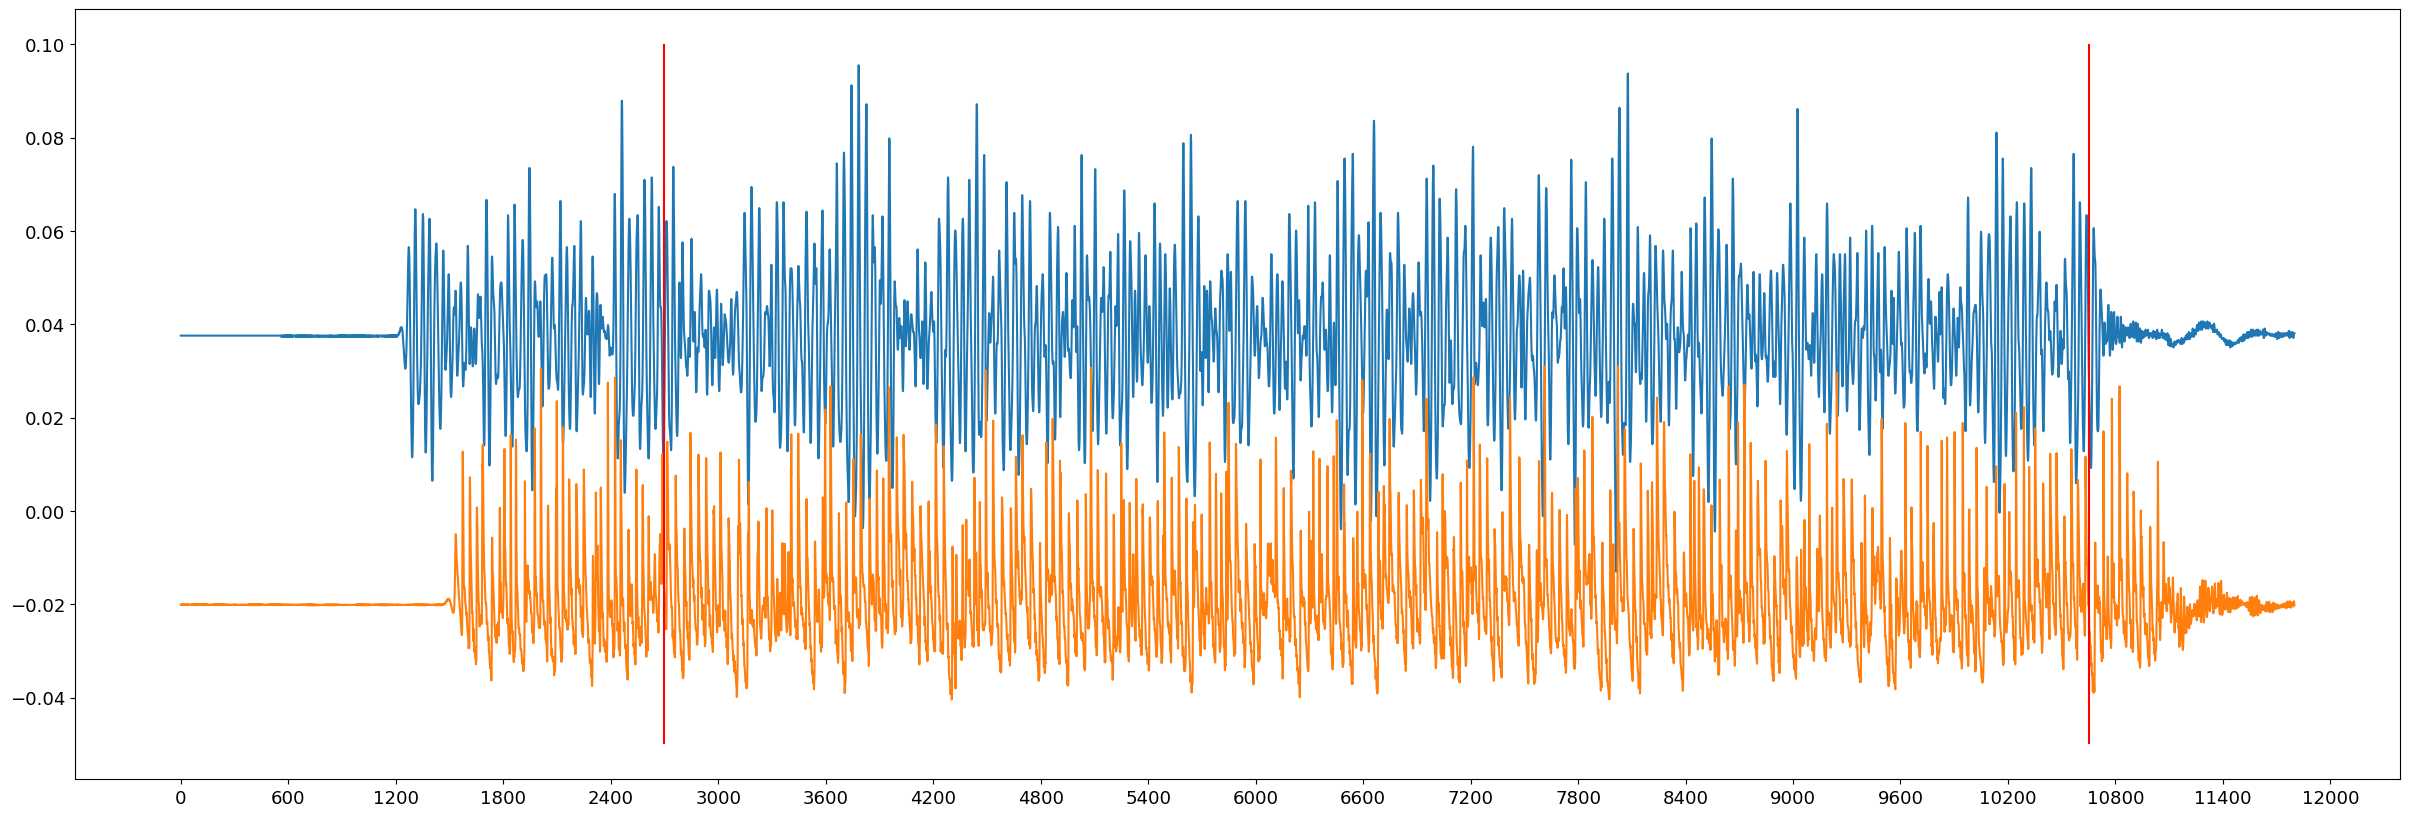

In [10]:
plt.figure(figsize=[30,10])
plt.plot(res['run1']['eta'][:,0])
plt.plot(res['run1']['eta'][:,-1])
plt.xticks(np.linspace(0, 12000, num=21));
plt.vlines([2700,10650],-0.05,0.1,colors='red')

cutoff_start = [2700]
cutoff_end = [10650]

60/0.05

1200.0

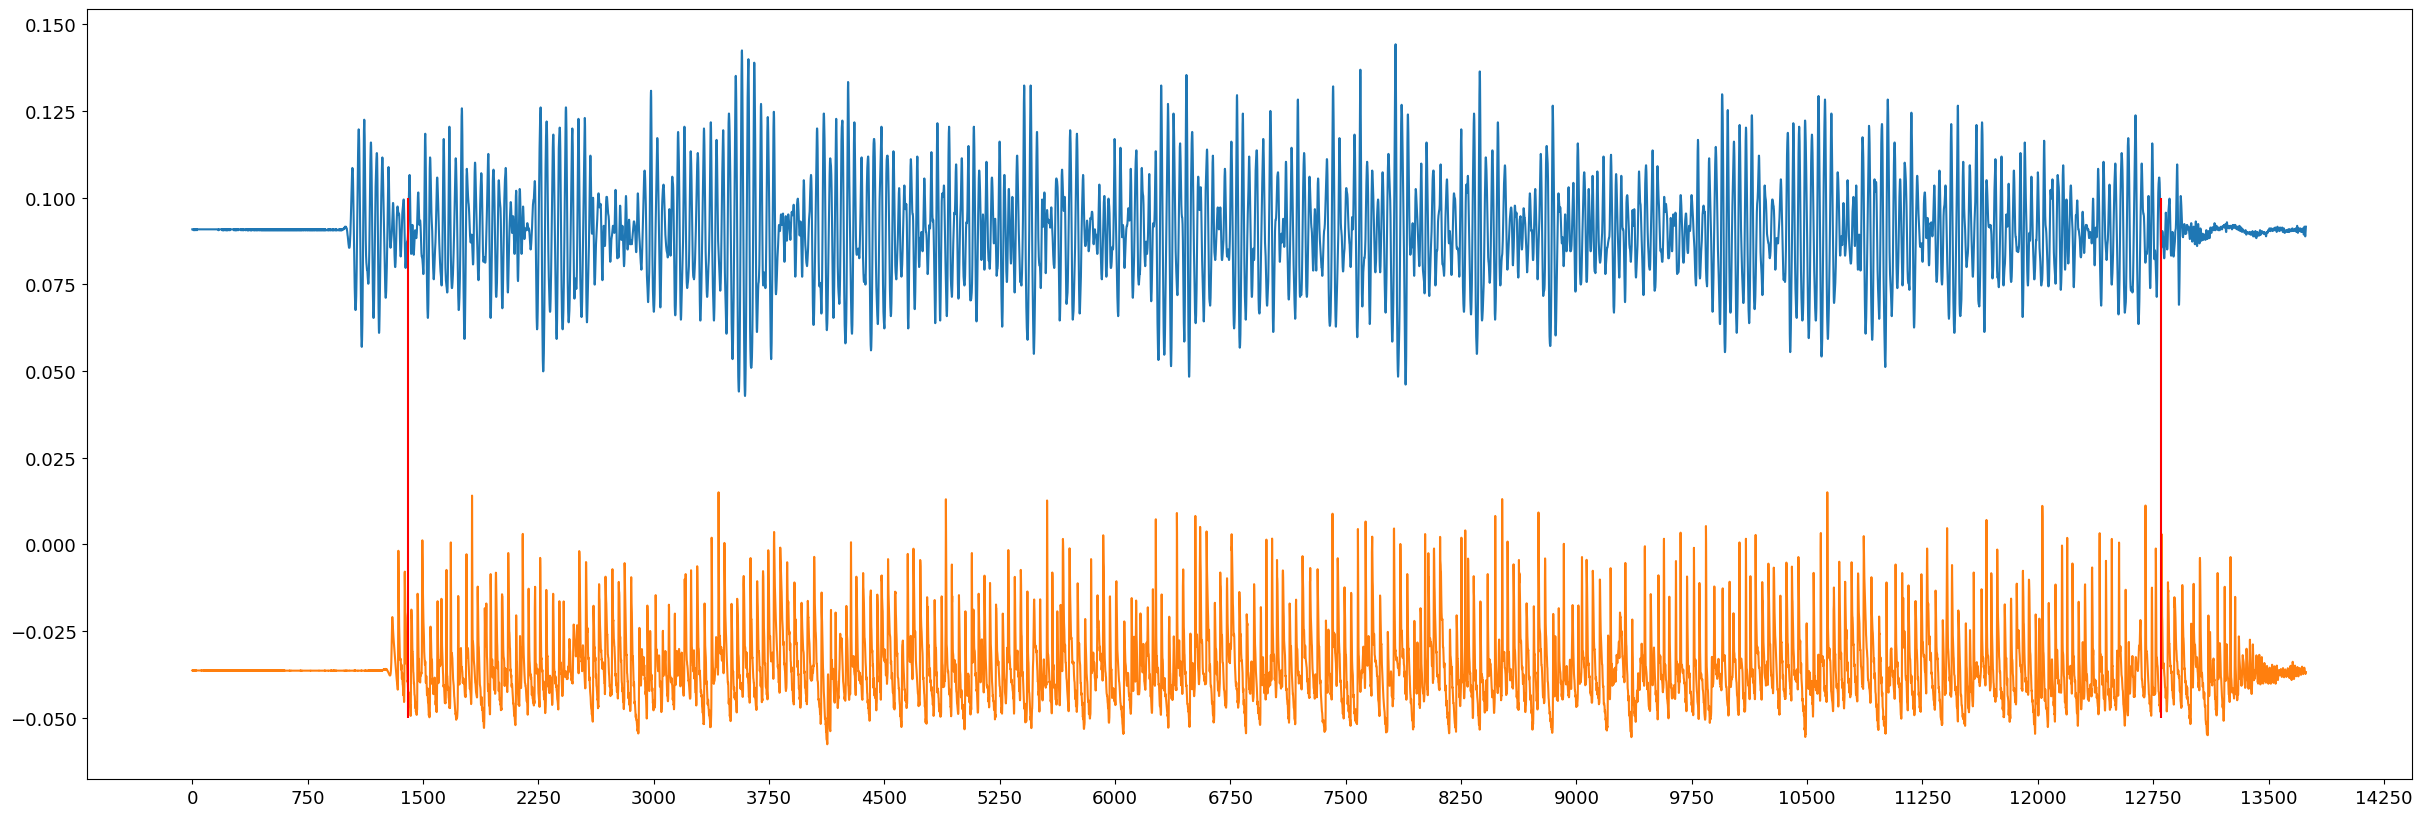

In [11]:
plt.figure(figsize=[30,10])
plt.plot(res['run2']['eta'][:,0])
plt.plot(res['run2']['eta'][:,-1])
plt.xticks(np.linspace(0, 15000, num=21));
plt.vlines([1400,12800],-0.05,0.1,colors='red')

cutoff_start.append(1400+1200)
cutoff_end.append(12800)

60/0.05

1200.0

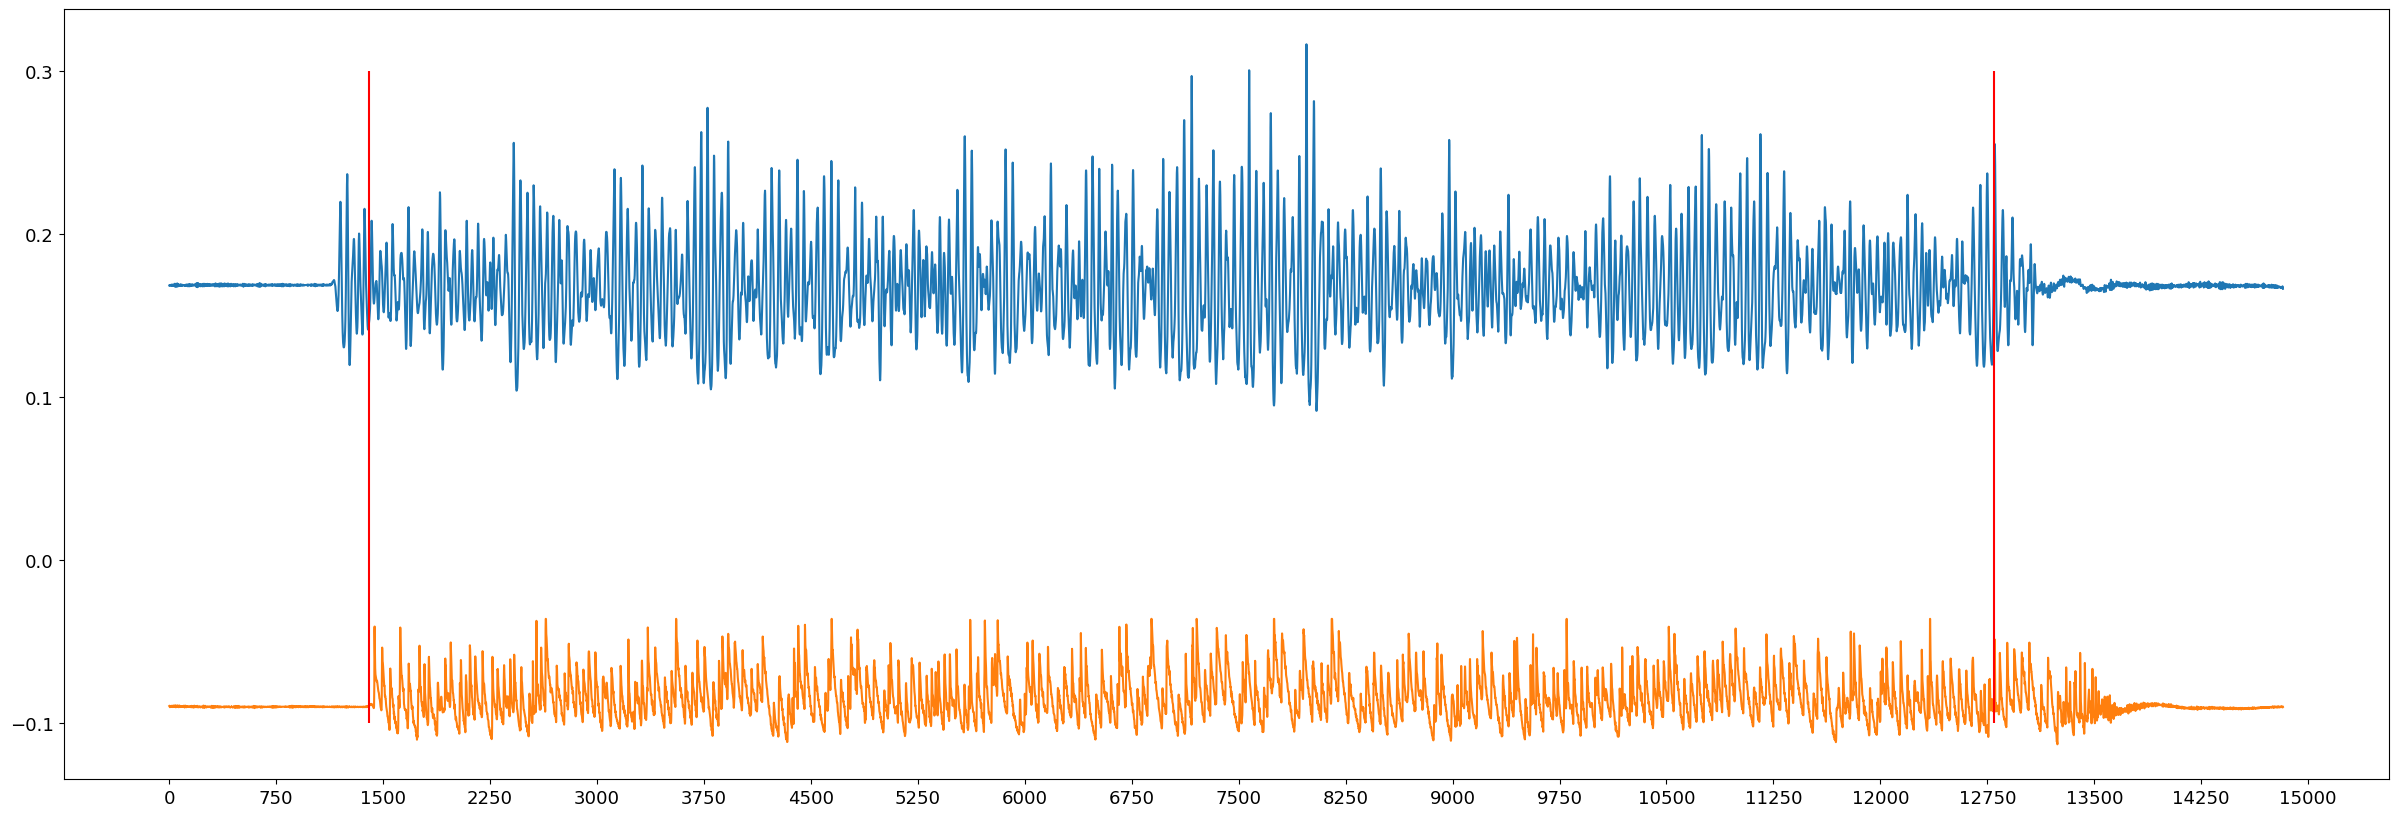

In [12]:
plt.figure(figsize=[30,10])
plt.plot(res['run4']['eta'][:,0])
plt.plot(res['run4']['eta'][:,-1])
plt.xticks(np.linspace(0, 15000, num=21));
plt.vlines([1400,12800],-0.1,0.3,colors='red')

cutoff_start.append(1400+1200)
cutoff_end.append(12800)

60/0.05

1200.0

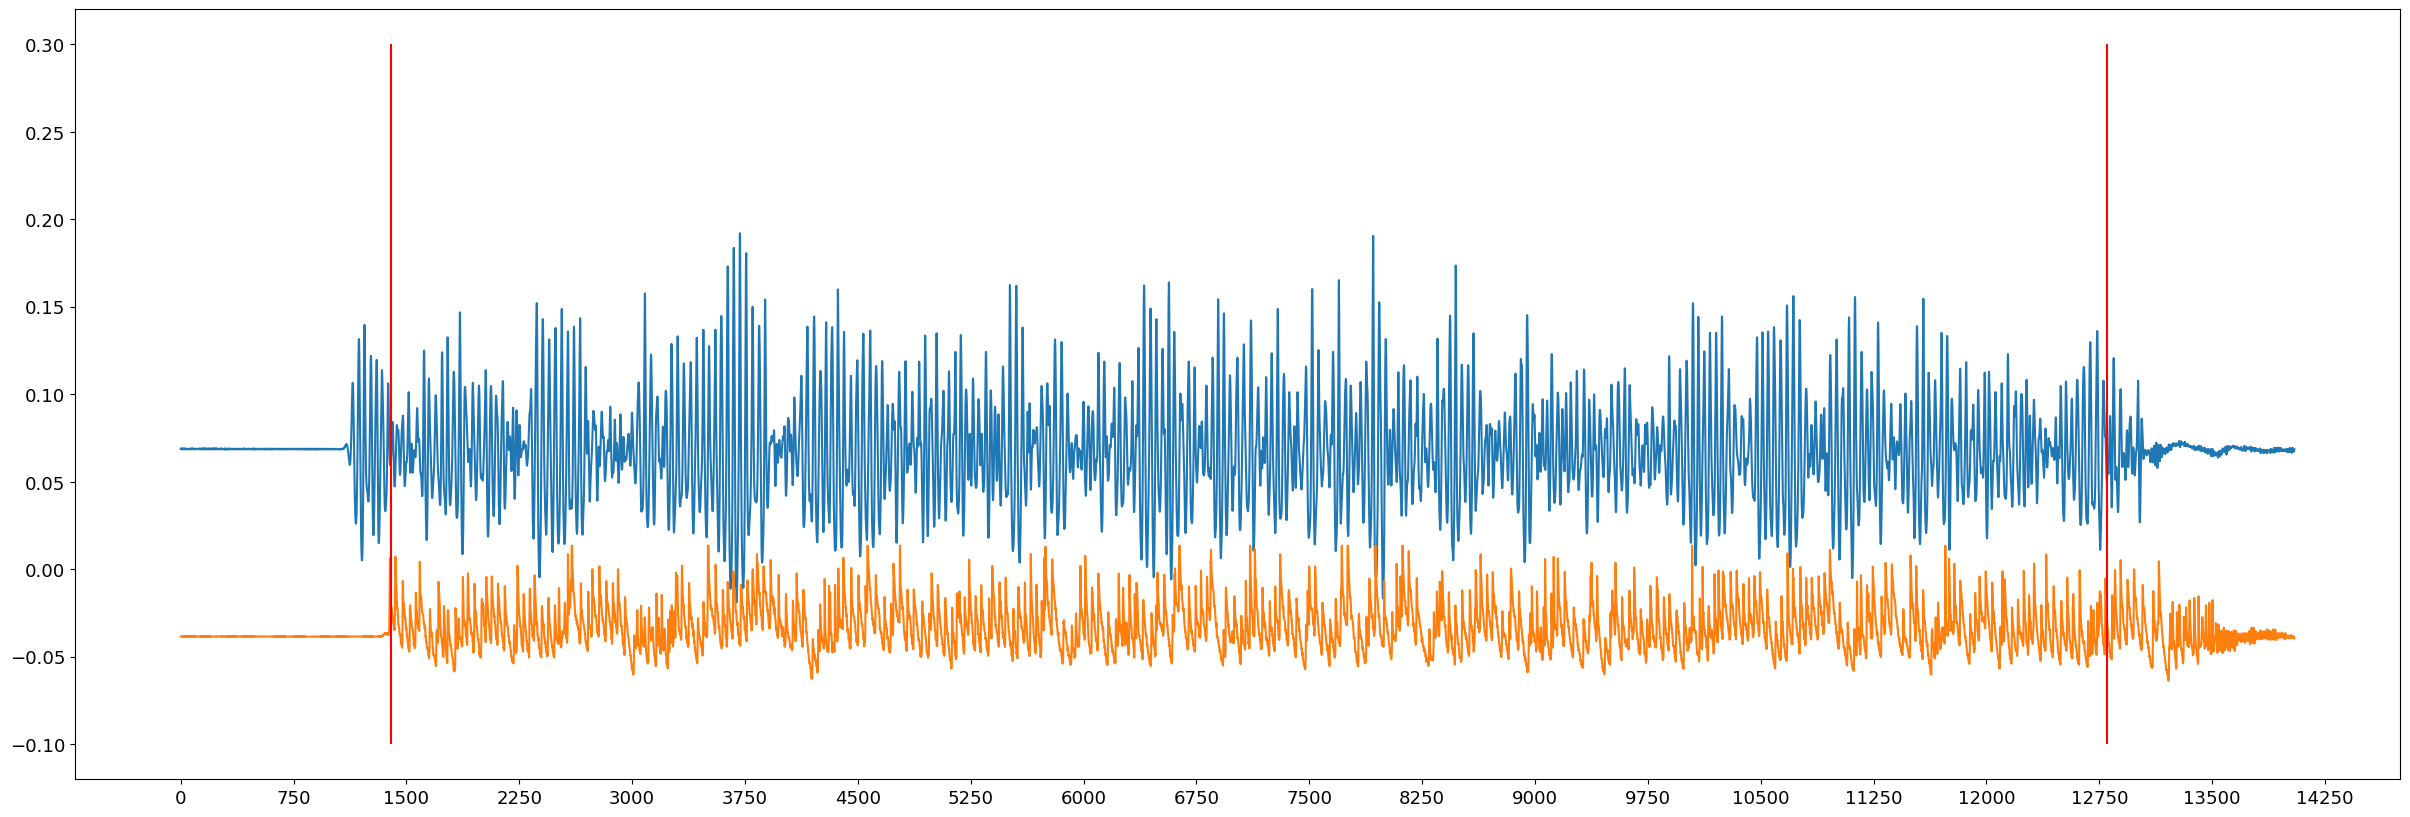

In [13]:
plt.figure(figsize=[30,10])
plt.plot(res['run5']['eta'][:,0])
plt.plot(res['run5']['eta'][:,-1])
plt.xticks(np.linspace(0, 15000, num=21));
plt.vlines([1400,12800],-0.1,0.3,colors='red')

cutoff_start.append(1400+1200)
cutoff_end.append(12800)

60/0.05

1200.0

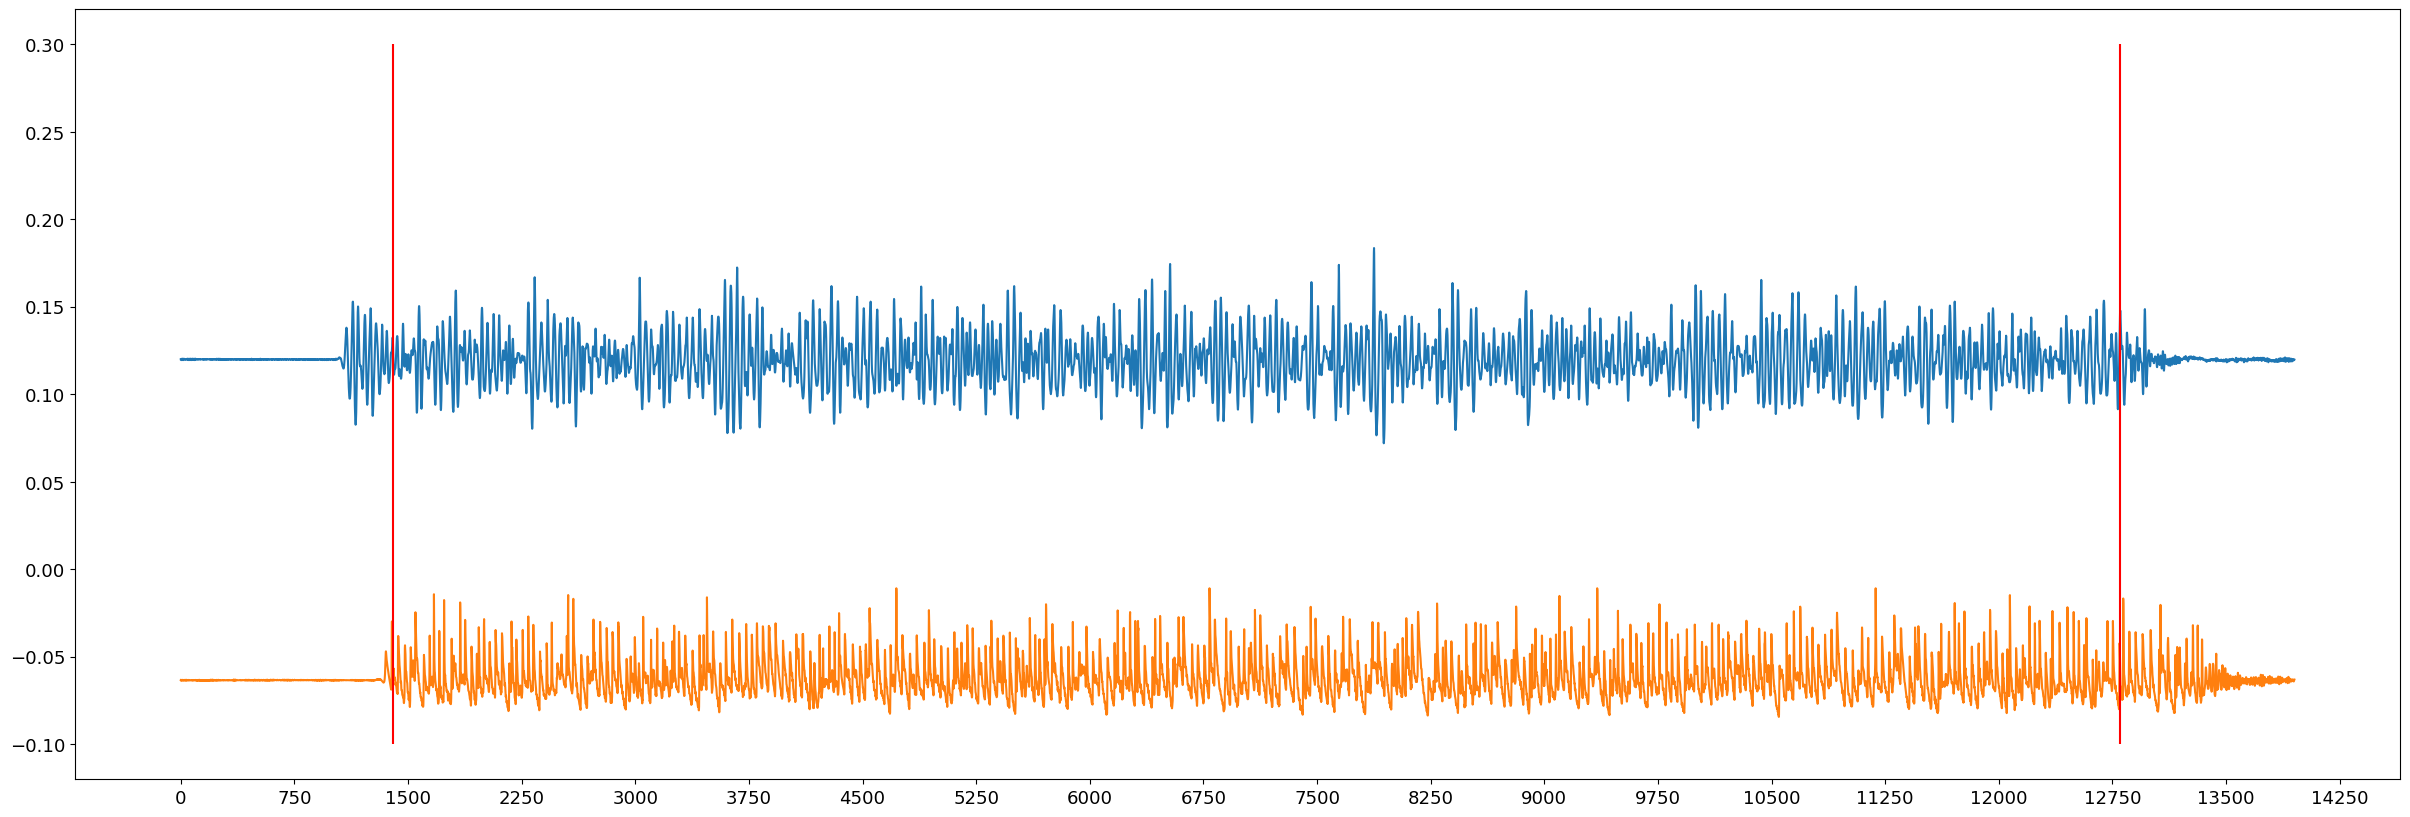

In [14]:
plt.figure(figsize=[30,10])
plt.plot(res['run6']['eta'][:,0])
plt.plot(res['run6']['eta'][:,-1])
plt.xticks(np.linspace(0, 15000, num=21));
plt.vlines([1400,12800],-0.1,0.3,colors='red')

cutoff_start.append(1400+1200)
cutoff_end.append(12800)

60/0.05

1200.0

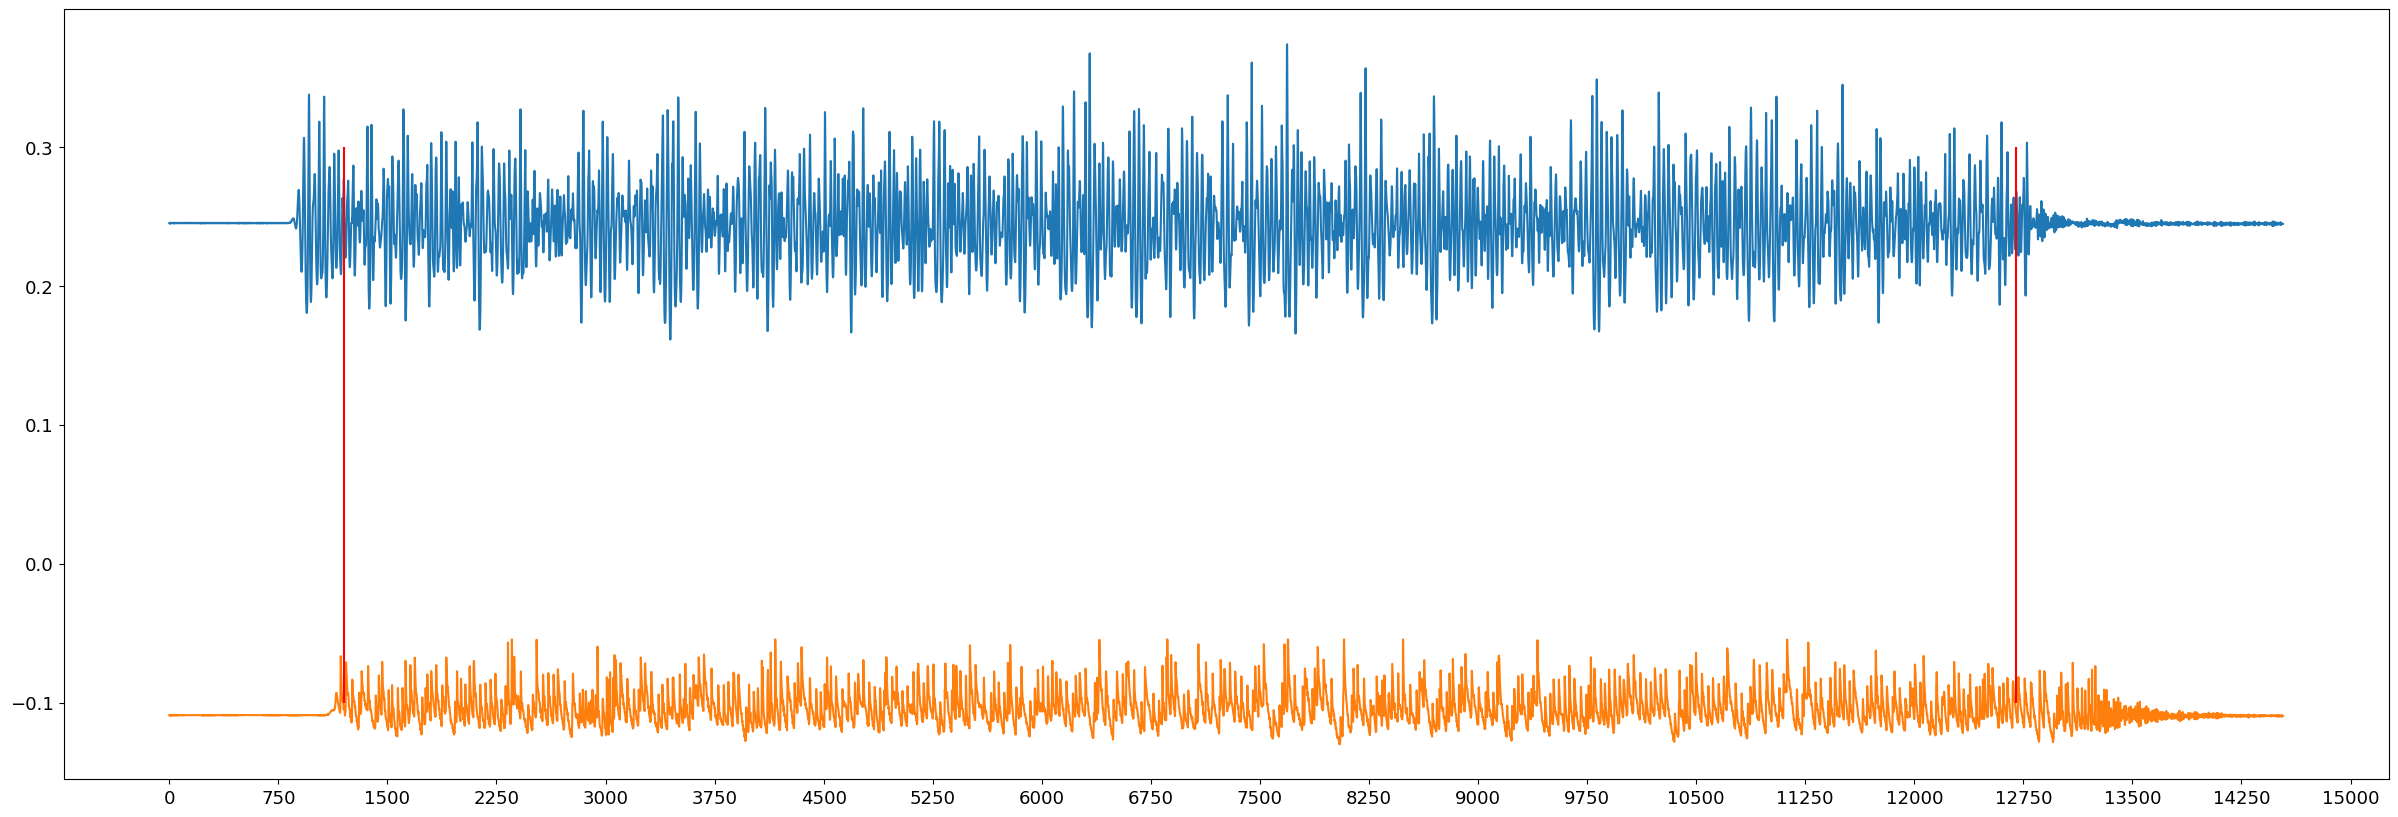

In [15]:
plt.figure(figsize=[30,10])
plt.plot(res['run8']['eta'][:,0])
plt.plot(res['run8']['eta'][:,-1])
plt.xticks(np.linspace(0, 15000, num=21));
plt.vlines([1200,12700],-0.1,0.3,colors='red')

cutoff_start.append(1200+1200)
cutoff_end.append(12700)

60/0.05

1200.0

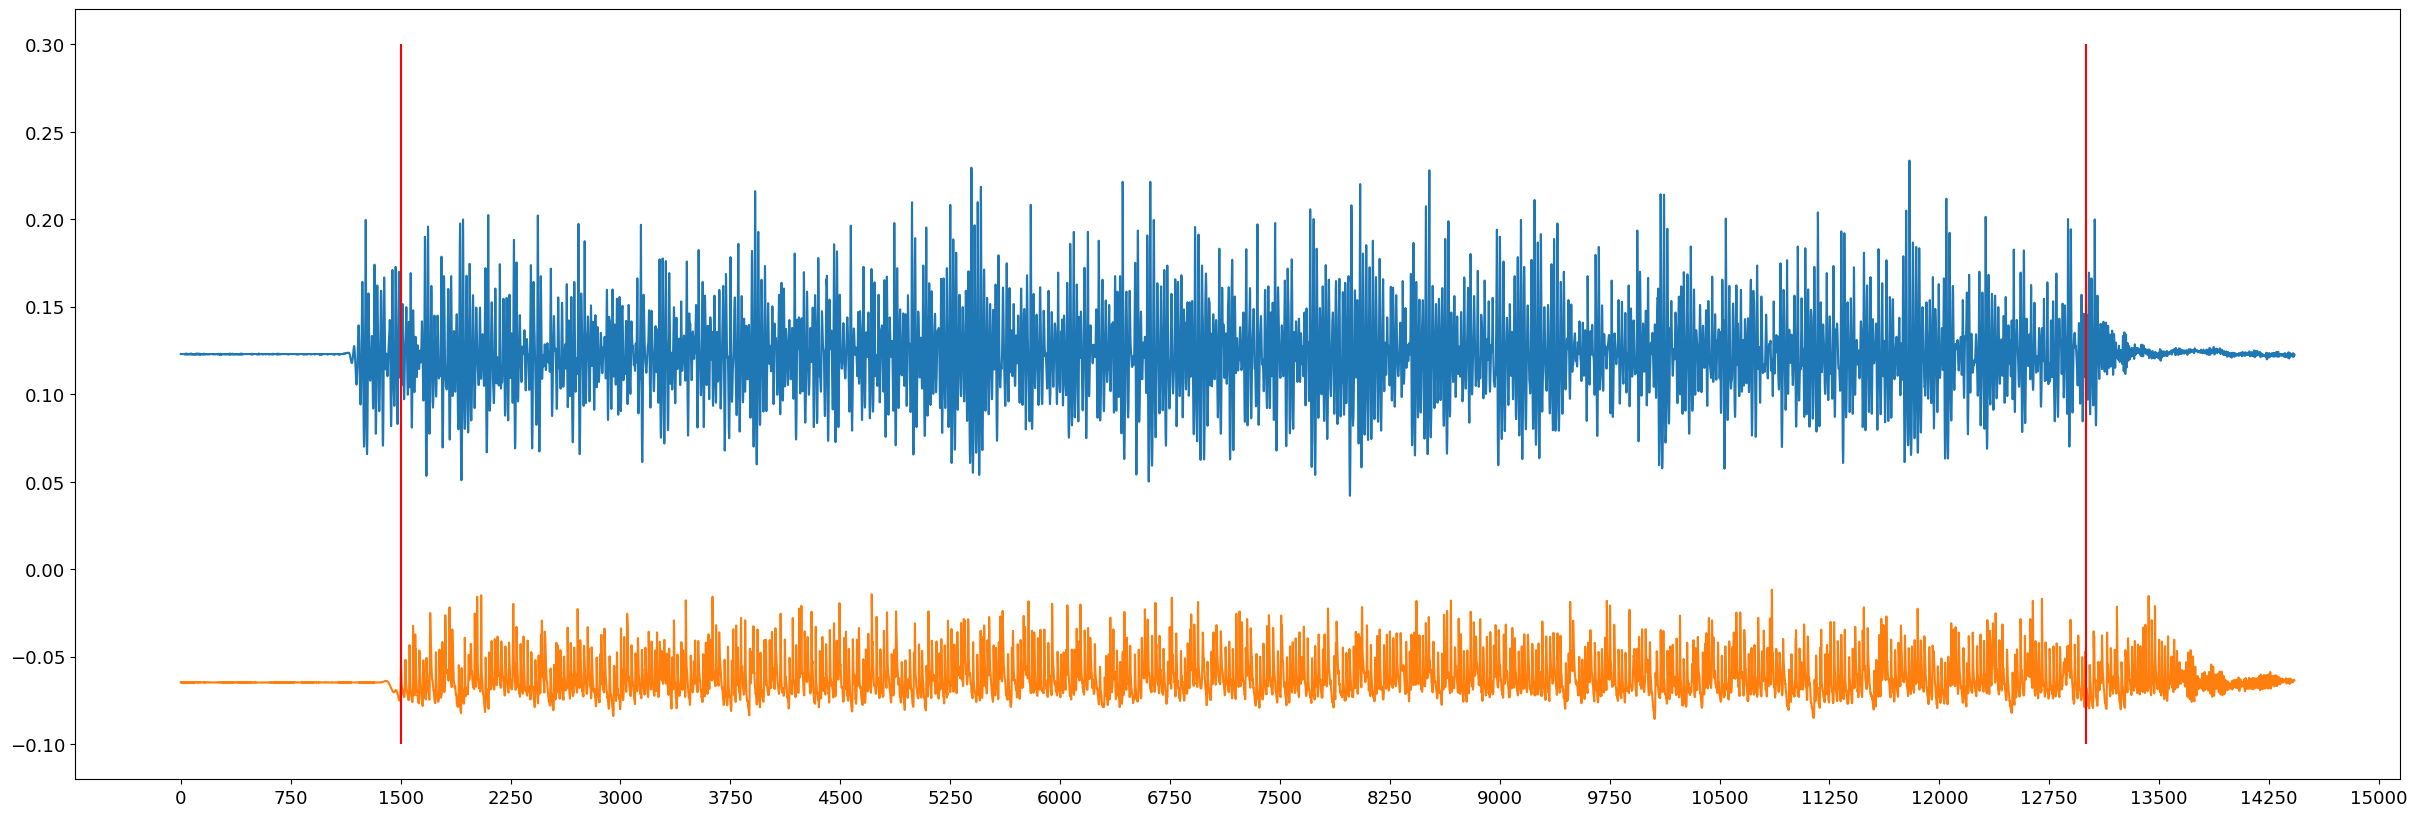

In [16]:
plt.figure(figsize=[30,10])
plt.plot(res['run9']['eta'][:,0])
plt.plot(res['run9']['eta'][:,-1])
plt.xticks(np.linspace(0, 15000, num=21));
plt.vlines([1500,13000],-0.1,0.3,colors='red')

cutoff_start.append(1500+1200)
cutoff_end.append(13000)

60/0.05

1200.0

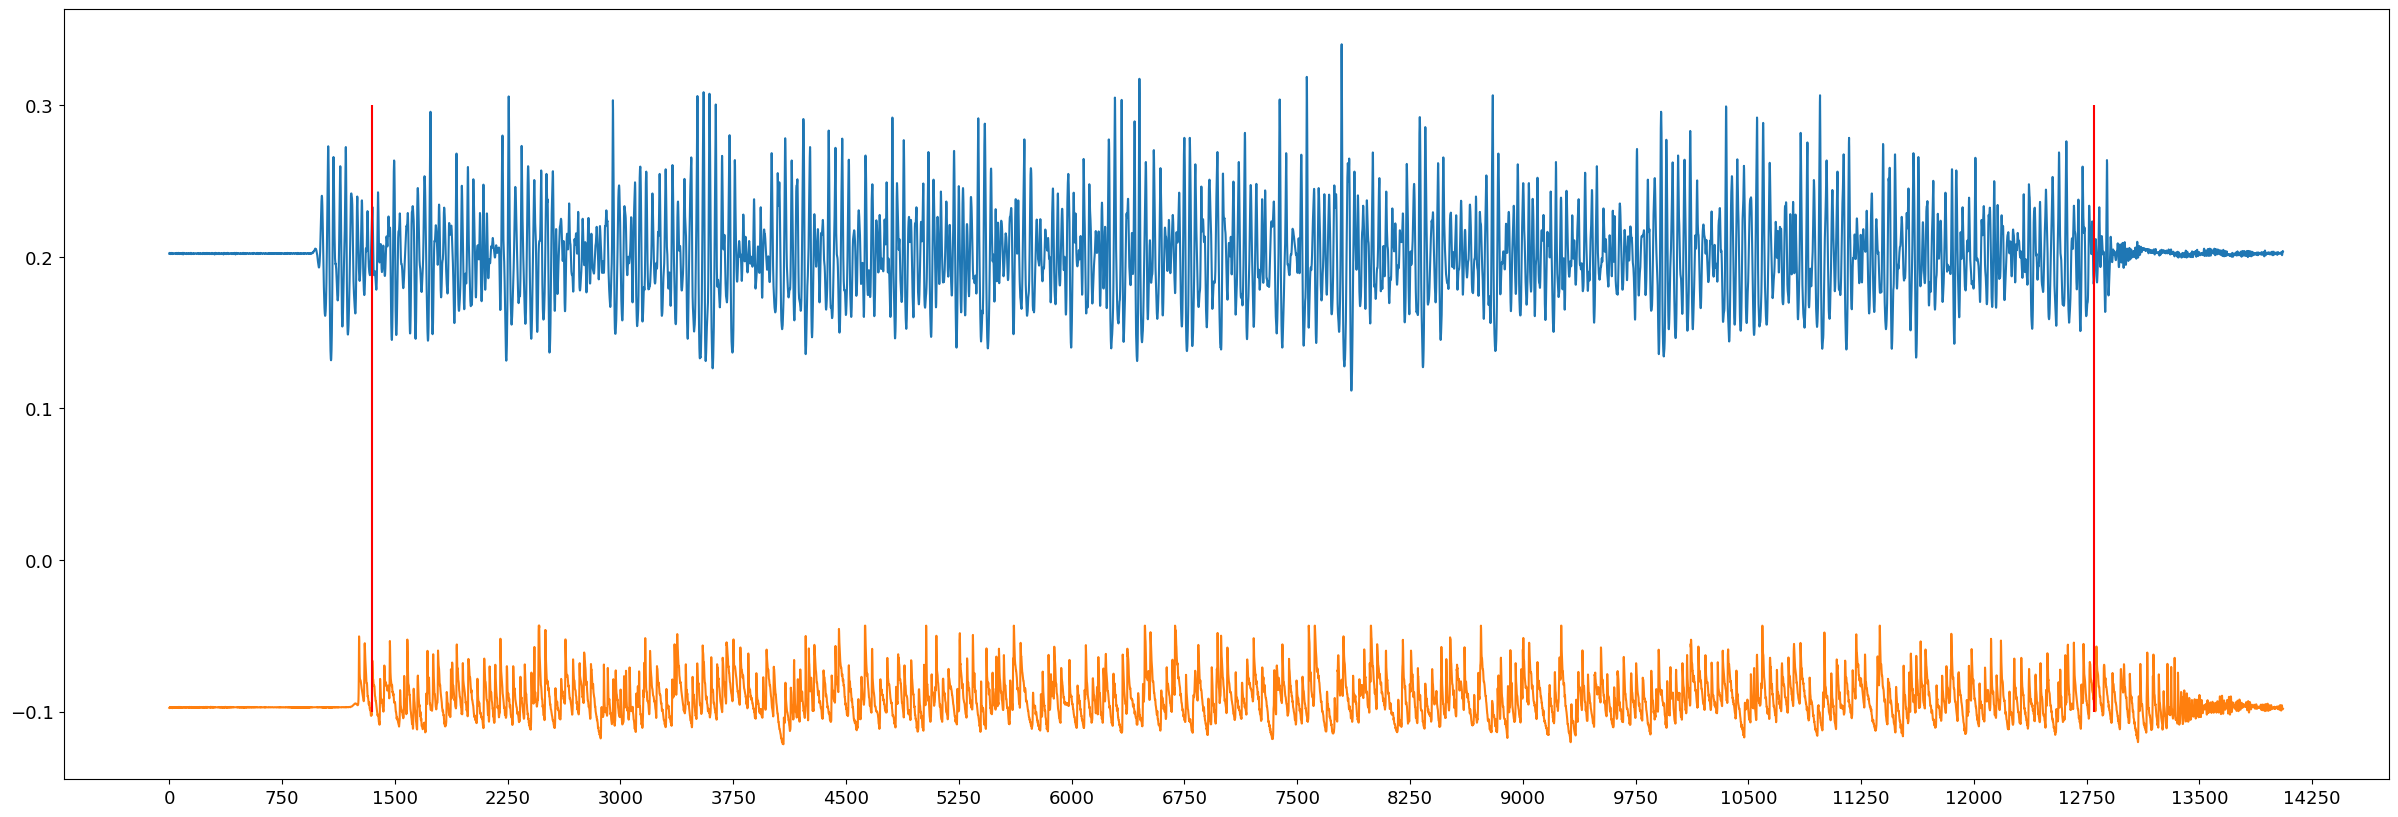

In [17]:
plt.figure(figsize=[30,10])
plt.plot(res['run10']['eta'][:,0])
plt.plot(res['run10']['eta'][:,-1])
plt.xticks(np.linspace(0, 15000, num=21));
plt.vlines([1350,12800],-0.1,0.3,colors='red')

cutoff_start.append(1350+1200)
cutoff_end.append(12800)

60/0.05

1200.0

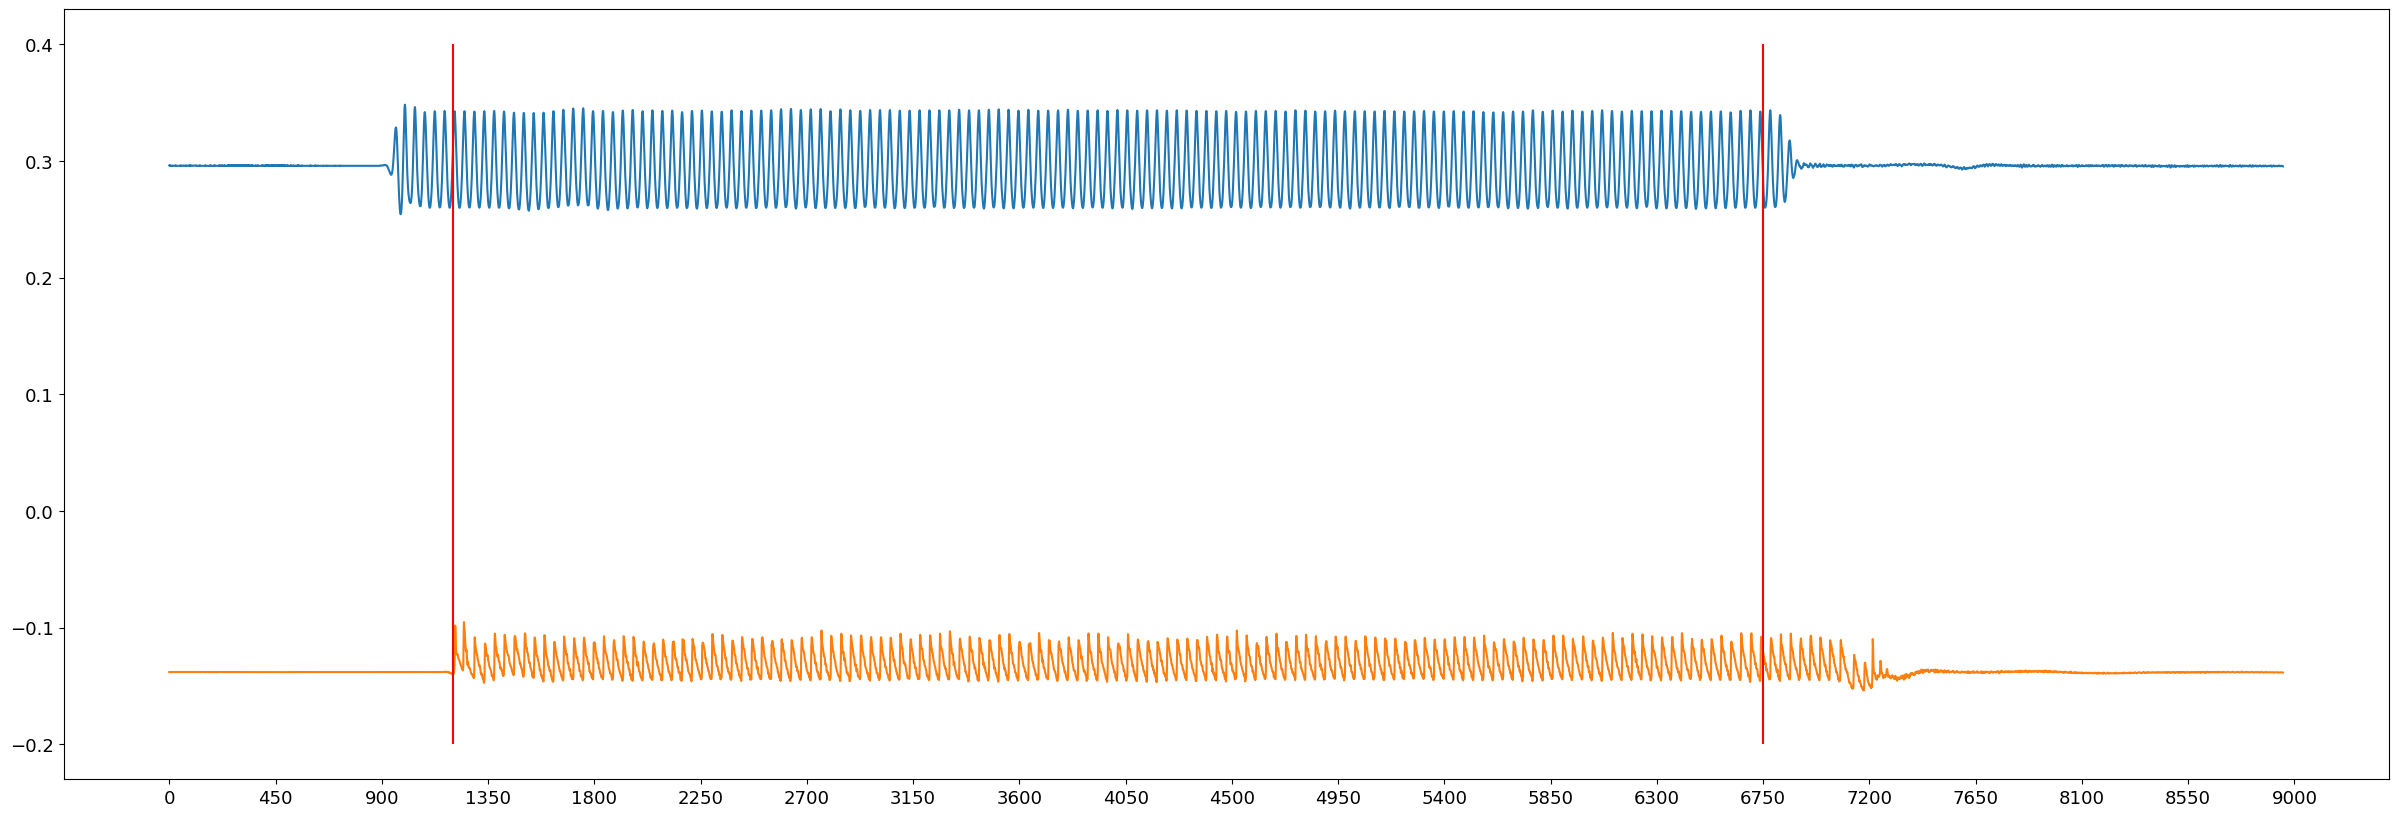

In [18]:
plt.figure(figsize=[30,10])
plt.plot(res['regular']['eta'][:,0])
plt.plot(res['regular']['eta'][:,-1])
plt.xticks(np.linspace(0, 9000, num=21));
plt.vlines([1200,6750],-0.2,0.4,colors='red')

cutoff_start.append(1200+1200)
cutoff_end.append(6750)

60/0.05

In [19]:
cutoff = np.column_stack([cutoff_start,cutoff_end])
print(cutoff[-1])
res['regular']['eta'][cutoff[-1],:]

[2400 6750]


array([[ 0.25989517,  0.21156981,  0.15154484,  0.1058007 ,  0.02627392,
        -0.12992   ],
       [ 0.27962917,  0.20462581,  0.11718284,  0.0631707 ,  0.02602992,
        -0.122139  ]])

In [20]:
# trim time series based on index from visual inspection
for i, d in enumerate(res.keys()):
    # print(i,d)
    res[d]['eta_trim']=np.copy(res[d]["eta"])
    # print(res[d]['eta_trim'].shape, cutoff_end[i]-cutoff_start[i])
    res[d]['eta_trim']=res[d]['eta'][cutoff_start[i]:cutoff_end[i],:]
    # print('after trim')
    # print(res[d]['eta_trim'].shape)

<hr style="height:1.5px;border:none;color:#333;" />
<h1 style="color:#00BFFF;"> Compare your input data to the measured data </h1>
<hr style="height:1.5px;border:none;color:#333;" />

Use the most offshore sensor to compute the significant wave height and peak period (following the computer laboratory on spectral analysis and associated lectures). How do the values compare? 

In [ ]:
# identify individual wave with zero crossing and calculate its time domain and frequency domain parameter
dt = res['run1']['time'][1]-res['run1']['time'][0]
fs = 1/dt

for d in res.keys():
    Hind =[]
    Tind = []
    f_all = [] # all channel
    E_all = [] # all channel
    SpecPar = []
    WavePar = []
    for i in range(6):
        H, T = wt.zero_crossing(detrend(res[d]['eta_trim'][:,i]),fs) #detrend data and identify individual wave
        Hind.append(H)
        Tind.append(T)
        WavePar.append(wt.wave_param(H,T)) #calculate time domain parameter
        eta_filter = wt.frequency_filter(res[d]['eta_trim'][:,i], Fs=fs, f_low=0.03, f_high=4) # band-pass filter
        E, f, _, _ = wt.wave_spectrum(eta_filter,nBlocks=16,Fs=fs) # spectral transformation
        SpecPar.append(wt.spectral_parameter(f,E)) # spectral parameter
        f_all.append(f)
        E_all.append(E)

        # print(d,'ch',i,H.shape,T.shape)
    # save in dictionary
    res[d]['H']=Hind
    res[d]['T']=Tind
    res[d]['f']=np.array(f_all).T
    res[d]['E']=np.array(E_all).T
    res[d]['Param']=np.column_stack([WavePar,SpecPar])



In [ ]:
#Plot Ranked Individual Wave Height 
for d in res.keys():
    plt.figure(figsize=[15,5])
    for i in range(6):
        plt.plot(np.flip(np.sort(res[d]['H'][i])),label=f'WG{i+1}')
    plt.legend()
    plt.xlabel('Rank')
    plt.ylabel('Individual Wave Height (m)')
    plt.title(d)
    plt.close()

In [ ]:
# Plot Spectral 1D
for d in res.keys():
    plt.figure(figsize=[15,5])
    for i in range(6):
        plt.plot(res[d]['f'][:,i],res[d]['E'][:,i],label=f'WG{i+1}')
    plt.legend()
    plt.xlabel('frequency (Hz)')
    plt.ylabel('E (m2s)')
    plt.title(d)
    plt.close()

In [ ]:
# Plot Spectral Evolution
x = [4,12,13,14,15,28]

for d in res.keys():
    plt.figure(figsize=[15,5])
    plt.pcolor(x,res[d]['f'][:,0],res[d]['E'])
    plt.ylabel('f [Hz]',fontsize=14)
    plt.xlabel('x [m]' ,fontsize=14)
    plt.ylim(0,3)
    plt.title('Variance density spectra')
    plt.colorbar();
    # plt.show()
    plt.close()

<hr style="height:1.5px;border:none;color:#333;" />
<h1 style="color:#00BFFF;"> Compare measurements to linear wave theory </h1>
<hr style="height:1.5px;border:none;color:#333;" />

Do flow velocity measurements match the amplitude flow velocities predicted by linear wave theory? This is a final quality control check. 
<br>
Use the significant wave height and significant wave period extracted from sensor 1, to compute the velocity amplitude ($û_x$, see lecture 2, Q2). You will require your measured EMF depth.

Plot part of your measured flow velocity. Are these values in the same order of magnitude as those predicted by linear wave theory? 
<br>
Don't expect an exact match as the measure flow velocity corresponds to an irregular wave field while the formula for the flow velocities correspond to regular waves.

<hr style="height:1.5px;border:none;color:#333;" />
Notebook made and updated by
<br>
- Joep Huijbregts
<br>
- Jaime Arriaga Garcia
<br>
- Marion Tissier 
<br>
- Ad Reniers

